In [2]:
# Import required libraries and dependencies
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import hvplot.pandas 

In [3]:
# Load the data into a Pandas DataFrame and make the index the "coin_id" column.
market_data_df = pd.read_csv("Resources/crypto_market_data.csv", index_col="coin_id")

# Display sample data
market_data_df.head()


,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,1.08388,7.60278,6.57509,7.67258,-3.25185,83.51840,37.51761
ethereum,0.22392,10.38134,4.80849,0.13169,-12.88890,186.77418,101.96023
tether,-0.21173,0.04935,0.00640,-0.04237,0.28037,-0.00542,0.01954
ripple,-0.37819,-0.60926,2.24984,0.23455,-17.55245,39.53888,-16.60193
bitcoin-cash,2.90585,17.09717,14.75334,15.74903,-13.71793,21.66042,14.49384


In [4]:
# Generate summary statistics
market_data_df.describe()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-0.269686,4.497147,0.185787,1.545693,-0.094119,236.537432,347.667956
std,2.694793,6.375218,8.376939,26.344218,47.365803,435.225304,1247.842884
min,-13.527860,-6.094560,-18.158900,-34.705480,-44.822480,-0.392100,-17.567530
25%,-0.608970,0.047260,-5.026620,-10.438470,-25.907990,21.660420,0.406170
50%,-0.063410,3.296410,0.109740,-0.042370,-7.544550,83.905200,69.691950
75%,0.612090,7.602780,5.510740,4.578130,0.657260,216.177610,168.372510
max,4.840330,20.694590,24.239190,140.795700,223.064370,2227.927820,7852.089700


### Prepare the Data

In [5]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
scaler = StandardScaler()

scaled_data = scaler.fit_transform(market_data_df)

In [6]:
# Create a DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=market_data_df.columns, index=market_data_df.index)

# Copy the crypto names from the original data
crypto_names = ['bitcoin', 'ethereum', 'tether', 'ripple', 'bitcoin-cash', 'binancecoin', 'chainlink', 'cardano', 'litecoin', 'bitcoin-cash-sV']

# Set the coinid column as index
scaled_df.index.name = 'coin_id'

# Display sample data
display(scaled_df.head())

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,0.508529,0.493193,0.772200,0.235460,-0.067495,-0.355953,-0.251637
ethereum,0.185446,0.934445,0.558692,-0.054341,-0.273483,-0.115759,-0.199352
tether,0.021774,-0.706337,-0.021680,-0.061030,0.008005,-0.550247,-0.282061
ripple,-0.040764,-0.810928,0.249458,-0.050388,-0.373164,-0.458259,-0.295546
bitcoin-cash,1.193036,2.000959,1.760610,0.545842,-0.291203,-0.499848,-0.270317


### Find the Best Value for k Using the Original Scaled DataFrame.

In [7]:
# Create a list with the number of k-values to try
# Use a range from 1 to 11
k_values = list(range(1, 11))

# Create an empty list to store the inertia values
inertia_values = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using the scaled DataFrame
# 3. Append the model.inertia_ to the inertia list
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    
    kmeans.fit(scaled_df)
    
    inertia_values.append(kmeans.inertia_)


# Create a dictionary with the data to plot the Elbow curve
elbow_data = {
    'k': k_values,
    'inertia': inertia_values
}

# Create a DataFrame with the data to plot the Elbow curve
elbow_df = pd.DataFrame(elbow_data)

# Display the DataFrame
display(elbow_df)

,k,inertia
0,1,287.000000
1,2,195.820218
2,3,123.190482
3,4,79.022435
4,5,66.217780
5,6,53.057788
6,7,44.406791
7,8,36.580835
8,9,32.848992
9,10,28.934610


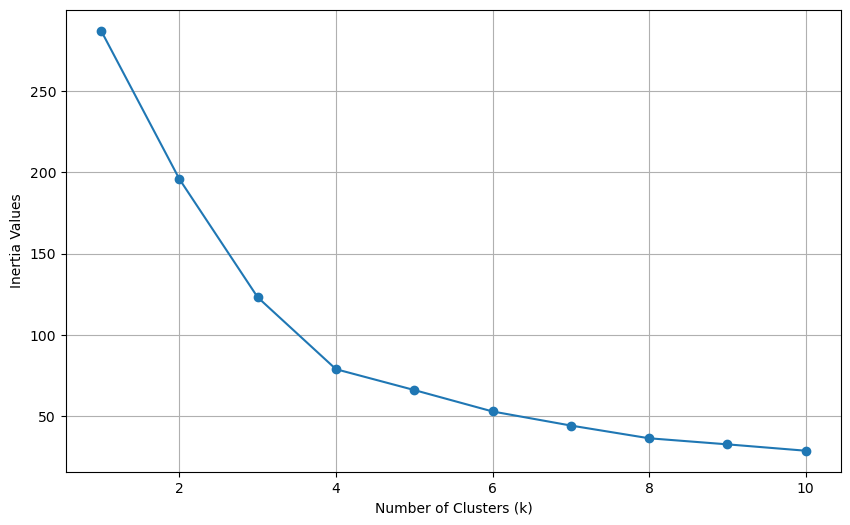

In [8]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
plt.figure(figsize=(10, 6))
plt.plot(elbow_data['k'], elbow_data['inertia'], marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia Values')
plt.grid(True)
plt.show()


#### Answer the following question: 
**Question:** What is the best value for `k`?

**Answer:** The best value for `k` is 4

### Cluster Cryptocurrencies with K-means Using the Original Scaled Data.

In [9]:
# Initialize the K-Means model using the best value for k
best_k = 4
kmeans = KMeans(n_clusters=best_k, n_init=10)


In [10]:
# Fit the K-Means model using the scaled data
kmeans.fit(scaled_df)

KMeans(n_clusters=4, n_init=10)

In [11]:
# Predict the clusters to group the cryptocurrencies using the scaled data
clusters = kmeans.predict(scaled_df)

# View the resulting array of cluster values.
clusters

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 3, 0, 0, 0, 0],
      dtype=int32)

In [12]:
# Create a copy of the DataFrame
clustered_data = market_data_df.copy()

In [13]:
# Add a new column to the DataFrame with the predicted clusters
clustered_data['Cluster'] = clusters

# Display sample data
clustered_data.head()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y,Cluster
coin_id,,,,,,,,
bitcoin,1.08388,7.60278,6.57509,7.67258,-3.25185,83.51840,37.51761,1
ethereum,0.22392,10.38134,4.80849,0.13169,-12.88890,186.77418,101.96023,1
tether,-0.21173,0.04935,0.00640,-0.04237,0.28037,-0.00542,0.01954,0
ripple,-0.37819,-0.60926,2.24984,0.23455,-17.55245,39.53888,-16.60193,0
bitcoin-cash,2.90585,17.09717,14.75334,15.74903,-13.71793,21.66042,14.49384,1


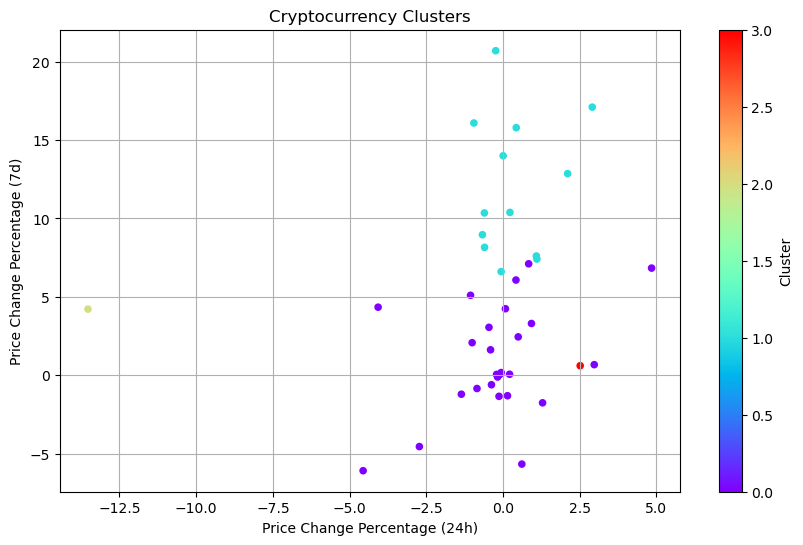

In [14]:
# Create a scatter plot using Pandas plot by setting 
# `x="price_change_percentage_24h"` and `y="price_change_percentage_7d"`.
# Use "rainbow" for the color to better visualize the data.
clustered_data.plot.scatter(
    x='price_change_percentage_24h',
    y='price_change_percentage_7d',
    c='Cluster',
    colormap='rainbow',
    figsize=(10,6))
plt.xlabel('Price Change Percentage (24h)')
plt.ylabel('Price Change Percentage (7d)')
plt.title('Cryptocurrency Clusters')
plt.grid(True)
plt.show()

### Optimize Clusters with Principal Component Analysis.

In [15]:
# Create a PCA model instance and set `n_components=3`.
pca_model = PCA(n_components=3)

In [16]:
# Use the PCA model with `fit_transform` on the original scaled DataFrame to reduce to three principal components.
pca_data = pca_model.fit_transform(scaled_df)

# View the first five rows of the DataFrame. 
print(pca_data[:5])

[[-0.60066733  0.84276006  0.46159457]
 [-0.45826071  0.45846566  0.95287678]
 [-0.43306981 -0.16812638 -0.64175193]
 [-0.47183495 -0.22266008 -0.47905316]
 [-1.15779997  2.04120919  1.85971527]]


In [17]:
# Retrieve the explained variance to determine how much information  can be attributed to each principal component.
explained_variance = pca_model.explained_variance_ratio_
total_variance = sum(explained_variance)

display(explained_variance)
display(total_variance)


array([0.3719856 , 0.34700813, 0.17603793])

0.8950316570309842

#### Answer the following question: 

**Question:** What is the total explained variance of the three principal components?

**Answer:** The total explained variance of the three principal components is 0.8950316570309842 which can be rounded to .9

In [18]:
# Create a new DataFrame with the PCA data.
# Note: The code for this step is provided for you

# Creating a DataFrame with the PCA data
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'], index=scaled_df.index)

# Copy the crypto names from the original data
crypto_names = scaled_df.index

# Set the coinid column as index
pca_df.index.name = 'coin_id'

# Display sample data
display(pca_df.head())

,PC1,PC2,PC3
coin_id,,,
bitcoin,-0.600667,0.842760,0.461595
ethereum,-0.458261,0.458466,0.952877
tether,-0.433070,-0.168126,-0.641752
ripple,-0.471835,-0.222660,-0.479053
bitcoin-cash,-1.157800,2.041209,1.859715


### Find the Best Value for k Using the PCA Data

In [19]:
# Create a list with the number of k-values to try
# Use a range from 1 to 11
# Create an empty list to store the inertia values
inertia_pca = []

k_values_pca = list(range(1, 12))


# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using PCA DataFrame.
# 3. Append the model.inertia_ to the inertia list
for k in k_values_pca:
    kmeans_pca = KMeans(n_clusters=k, n_init=10)
    kmeans_pca.fit(pca_df)
    inertia_pca.append(kmeans_pca.inertia_)


# Create a dictionary with the data to plot the Elbow curve
elbow_data_pca = {
    'k': k_values_pca,
    'inertia': inertia_pca
}

# Create a DataFrame with the data to plot the Elbow curve
elbow_df_pca = pd.DataFrame(elbow_data_pca)

# Display the DataFrame
display(elbow_df_pca)

,k,inertia
0,1,256.874086
1,2,165.901994
2,3,93.774626
3,4,49.665497
4,5,37.878747
5,6,27.618972
6,7,21.134056
7,8,17.016962
8,9,13.593650
9,10,10.559358


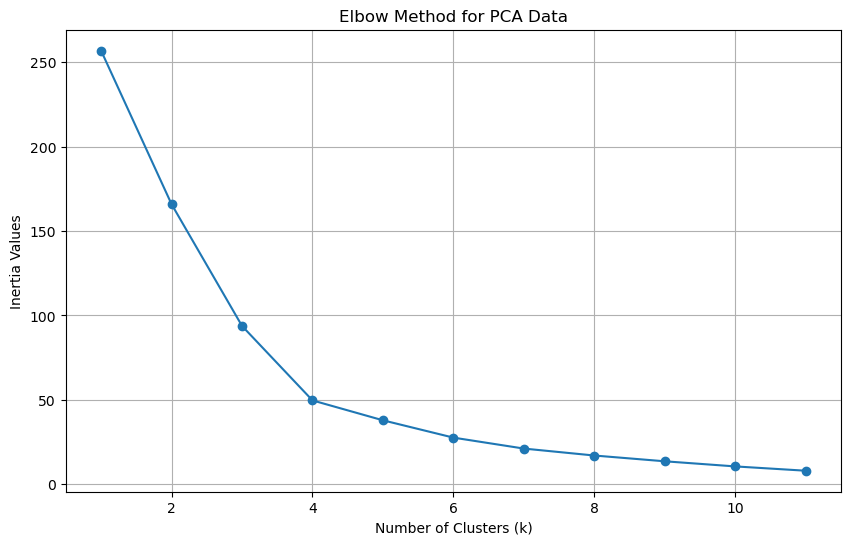

In [20]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
plt.figure(figsize=(10, 6))
plt.plot(elbow_df_pca['k'], elbow_df_pca['inertia'], marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia Values')
plt.title('Elbow Method for PCA Data')
plt.grid(True)
plt.show()

#### Answer the following questions: 
* **Question:** What is the best value for `k` when using the PCA data?

  * **Answer:** 
The best value for `k` when using the PCA data is 4

* **Question:** Does it differ from the best k value found using the original data?

  * **Answer:** 
It does not differ from the best k value found using the original data

### Cluster Cryptocurrencies with K-means Using the PCA Data

In [21]:
# Initialize the K-Means model using the best value for k
best_k_pca = 4
kmeans_pca = KMeans(n_clusters=best_k_pca, n_init=10)

In [22]:
# Fit the K-Means model using the PCA data
kmeans_pca.fit(pca_data)

KMeans(n_clusters=4, n_init=10)

In [23]:
# Predict the clusters to group the cryptocurrencies using the PCA data
clusters_pca = kmeans_pca.predict(pca_data)

# Print the resulting array of cluster values.
clusters_pca

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 3, 0, 1, 1, 2, 1, 1, 1, 1],
      dtype=int32)

In [24]:
# Create a copy of the DataFrame with the PCA data
pca_clustered_data = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2', 'PC3'], index=scaled_df.index)

# Add a new column to the DataFrame with the predicted clusters
pca_clustered_data['Cluster'] = clusters_pca

# Display sample data
pca_clustered_data.head()

,PC1,PC2,PC3,Cluster
coin_id,,,,
bitcoin,-0.600667,0.842760,0.461595,0
ethereum,-0.458261,0.458466,0.952877,0
tether,-0.433070,-0.168126,-0.641752,1
ripple,-0.471835,-0.222660,-0.479053,1
bitcoin-cash,-1.157800,2.041209,1.859715,0


In [25]:
# Create a scatter plot using hvPlot by setting `x="PCA1"` and `y="PCA2"`. 
import hvplot.pandas

scatter_plot = pca_clustered_data.hvplot.scatter(
    x = 'PC1',
    y = 'PC2',
    by = 'Cluster',
    colormap = 'viridis',
    width = 500,
    height = 500
)

scatter_plot
#hvplot.show(scatter_plot)

:NdOverlay   [Cluster]
   :Scatter   [PC1]   (PC2)

**Question** What is the impact of using fewer features to cluster the data using KMeans?

**Answer** The impact of using fewer features to cluster the data using KMeans is a simplified representation of the data.

### Determine the Weights of Each Feature on each Principal Component

In [26]:
# Use the columns from the original scaled DataFrame as the index.
component_weights_df = pd.DataFrame(pca_model.components_, columns=scaled_df.columns, index=['PC1', 'PC2', 'PC3'])

component_weights_df

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
PC1,-0.416728,-0.102432,-0.009162,0.191523,0.320365,0.594468,0.568379
PC2,0.358162,0.227432,0.540415,0.562182,0.434040,0.027735,-0.150789
PC3,-0.218795,0.787670,0.349534,-0.181744,-0.361377,0.039733,0.210541


#### Answer the following question: 

* **Question:** Which features have the strongest positive or negative influence on each component? 
 
* **Answer:** The strongest positive influence for PC1 is price_change_percentage_200d and price_change_percentage_1y, while the strongest negative influence is price_change_percentage_24h. Similarly, for PC3, the strongest positive influence is price_change_percentage_7d, and the strongest negative influence is price_change_percentage_24h. PC2 doesn't have a standout feature with a strong negative influence.
    